## Applying Model (Random Forest)

### Loading data

In [63]:
import pandas as pd

# Load the Parquet file
pricee_s_a = pd.read_parquet('../data/processed/price_features.parquet')

# Preview the data
pricee_s_a.head()


,date,symbol,open,close,low,high,volume,close_lag1,log_return_1d,target_next_day_return,...,rolling_mean_5,rolling_mean_10,rolling_std_5,rolling_std_10,momentum_5,momentum_10,volume_change_1d,volume_zscore_10,high_low_ratio,close_open_ratio
0,2010-01-19,A,21.716737,22.031474,21.709585,22.052933,3563600.0,21.766810,0.012086,-0.005535,...,21.962804,22.014306,0.210961,0.153942,0.003127,0.000780,-0.229758,-0.405386,1.015815,1.014493
1,2010-01-20,A,21.838340,21.909872,21.595137,21.938484,4589000.0,22.031474,-0.005535,-0.003598,...,21.988555,21.990701,0.190062,0.149553,-0.003578,-0.003676,0.287743,0.571001,1.015899,1.003275
2,2010-01-21,A,22.174536,21.831188,21.587982,22.253220,6081400.0,21.909872,-0.003598,-0.045241,...,21.964235,21.967096,0.203115,0.154671,-0.006057,-0.006187,0.325212,1.536435,1.030815,0.984516
3,2010-01-22,A,21.709585,20.865522,20.808298,21.709585,4263000.0,21.831188,-0.045241,0.009553,...,21.680973,21.849786,0.466406,0.378012,-0.037611,-0.045047,-0.299010,-0.134568,1.043314,0.961120
4,2010-01-25,A,21.044350,21.065809,20.908441,21.208870,3608500.0,20.865522,0.009553,-0.005448,...,21.540773,21.753219,0.534536,0.444022,-0.022050,-0.031600,-0.153530,-0.719029,1.014369,1.001020


In [64]:
## View all column names
pricee_s_a.columns


Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume',
       'close_lag1', 'log_return_1d', 'target_next_day_return',
       'price_up_tomorrow', 'log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio'],
      dtype='object')

### Check for Infinite Values

In [65]:
## Check for Infinite Values
import numpy as np


# Select only numeric columns
numeric_cols = pricee_s_a.select_dtypes(include=[np.number])

# Check for infinite values
infinite_counts = np.isinf(numeric_cols).sum()
print("Infinite values per column:")
print(infinite_counts)



Infinite values per column:
open                       0
close                      0
low                        0
high                       0
volume                     0
close_lag1                 0
log_return_1d              0
target_next_day_return     0
price_up_tomorrow          0
log_return_lag1            0
log_return_lag2            0
log_return_lag3            0
rolling_mean_5             0
rolling_mean_10            0
rolling_std_5              0
rolling_std_10             0
momentum_5                 0
momentum_10                0
volume_change_1d          16
volume_zscore_10           0
high_low_ratio             0
close_open_ratio           0
dtype: int64


### Drop infinite values in the dataset

In [66]:
## Drop Infinite Values

# Drop the column completely
pricee_s_a.drop(columns=['volume_change_1d'], inplace=True)


### Feature Importance with Random Forest

            Feature  Importance
0     log_return_1d    0.200558
3       momentum_10    0.200338
1    high_low_ratio    0.200071
2  close_open_ratio    0.199638
4     rolling_std_5    0.199395


C:\Users\faisa\AppData\Local\Temp\ipykernel_33772\4091485366.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Blues_r')


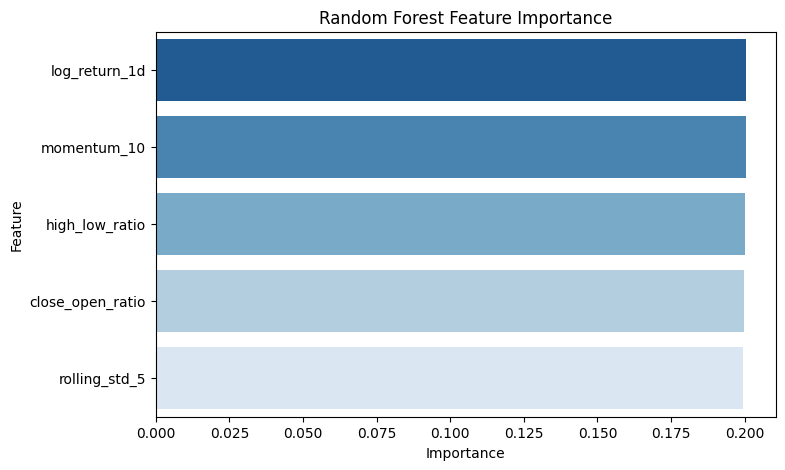

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_

# Put into a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Blues_r')
plt.title("Random Forest Feature Importance")
plt.show()


### Key Observation
log_return_1d is the most important feature followed by momentum_10, high_low_ratio, and close_open_ratio, indicating they are nearly equally influential while rolling_std_5 is slightly less important but still significant

The model relies heavily on short-term return metrics (log_return_1d) and momentum indicators, which are typical in financial time series modeling.

Price range features like high_low_ratio and close_open_ratio also play a major role, suggesting the model captures volatility and intraday movement.

### Training the Model

              precision    recall  f1-score   support

           0       0.50      0.47      0.48     81889
           1       0.53      0.56      0.54     87261

    accuracy                           0.51    169150
   macro avg       0.51      0.51      0.51    169150
weighted avg       0.51      0.51      0.51    169150



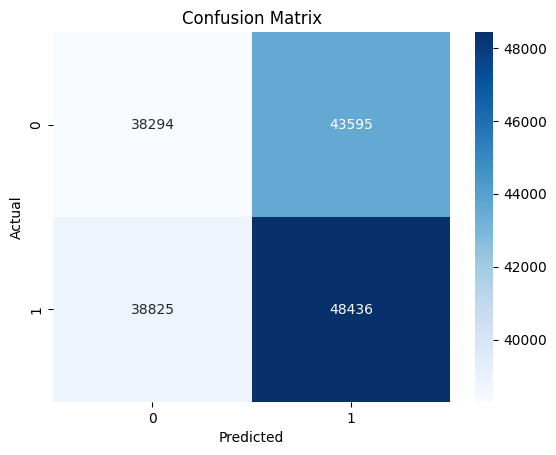

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Define Features with more predective power (less multicollinearity) and Target
features = [
    'log_return_1d',
    'high_low_ratio',
    'close_open_ratio',
    'momentum_10',
    'rolling_std_5',
]


X = pricee_s_a[features]
y = pricee_s_a['price_up_tomorrow'] # Binary classification: up or down

## Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Train the Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

## Evaluate the Model
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




### Key Observations
Despite using strong features, the model struggles to generalize — possibly due to:

Feature redundancy or noise

Class overlap or imbalance

Need for hyperparameter tuning or alternative models

The confusion matrix suggest low signal-to-noise ratio in the selected features.